In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
data_dir = "/kaggle/input/brain-tumor-mri-dataset"
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'

In [4]:
transform_train = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),  
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],   
                         [0.229, 0.224, 0.225])   
])

transform_test = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),  
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [5]:
from torch.utils.data import random_split

full_train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
val_size = int(len(full_train_dataset) * 0.2)
train_size = len(full_train_dataset) - val_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
train_dataset = datasets.ImageFolder(root=f"{data_dir}/Training", transform=transform_train)
test_dataset  = datasets.ImageFolder(root=f"{data_dir}/Testing", transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
print("Classes:", train_dataset.classes)
print("Number of classes:", len(train_dataset.classes))

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of classes: 4


In [9]:
for _, labels in train_loader:
    print("Min label:", labels.min().item(), "Max label:", labels.max().item())
    break

Min label: 0 Max label: 3


In [10]:
device = torch.device("cpu")

In [11]:
num_classes = len(train_dataset.classes)

In [12]:
teacher = models.resnet101(pretrained=True)
teacher.fc = nn.Linear(teacher.fc.in_features, num_classes)
teacher = teacher.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher.parameters(), lr=1e-4)

def train_teacher(epochs=10):
    teacher.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

           
            if epoch == 0 and i == 0:
                print("Batch images shape:", images.shape)  
                print("Batch labels min/max:", labels.min().item(), labels.max().item())

            optimizer.zero_grad()
            outputs = teacher(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

        
        evaluate(teacher, val_loader)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
student = models.mobilenet_v3_small(pretrained=True)
student.classifier[3] = nn.Linear(student.classifier[3].in_features, num_classes)
student = student.to(device)

def kd_loss(student_logits, teacher_logits, labels, alpha=0.5, T=4):
    hard_loss = F.cross_entropy(student_logits, labels)
    soft_loss = F.kl_div(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1),
        reduction='batchmean'
    ) * (T * T)
    return alpha * hard_loss + (1 - alpha) * soft_loss

optimizer_student = optim.Adam(student.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
def train_student(epochs=5):
    teacher.eval()
    student.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer_student.zero_grad()
            with torch.no_grad():
                teacher_outputs = teacher(images)
            student_outputs = student(images)
            loss = kd_loss(student_outputs, teacher_outputs, labels)
            loss.backward()
            optimizer_student.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], KD Loss: {running_loss/len(train_loader):.4f}")
        
        evaluate(student, val_loader)

In [15]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}%")
    return acc

In [16]:
train_teacher(epochs=10)

Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels min/max: 0 3
Epoch [1/10], Loss: 0.2288
Accuracy: 97.55%
Epoch [2/10], Loss: 0.2172
Accuracy: 97.46%
Epoch [3/10], Loss: 0.1059
Accuracy: 90.89%
Epoch [4/10], Loss: 0.0977
Accuracy: 93.08%
Epoch [5/10], Loss: 0.0704
Accuracy: 98.60%
Epoch [6/10], Loss: 0.0638
Accuracy: 97.11%
Epoch [7/10], Loss: 0.0629
Accuracy: 98.51%
Epoch [8/10], Loss: 0.0681
Accuracy: 99.04%
Epoch [9/10], Loss: 0.0324
Accuracy: 97.37%
Epoch [10/10], Loss: 0.0442
Accuracy: 99.30%


In [17]:
train_student(epochs=10)

100%|██████████| 179/179 [11:01<00:00,  3.69s/it]


Epoch [1/10], KD Loss: 2.6574
Accuracy: 77.93%


100%|██████████| 179/179 [10:44<00:00,  3.60s/it]


Epoch [2/10], KD Loss: 0.8688
Accuracy: 95.36%


100%|██████████| 179/179 [10:49<00:00,  3.63s/it]


Epoch [3/10], KD Loss: 0.4803
Accuracy: 96.06%


100%|██████████| 179/179 [10:51<00:00,  3.64s/it]


Epoch [4/10], KD Loss: 0.3433
Accuracy: 96.50%


100%|██████████| 179/179 [10:48<00:00,  3.62s/it]


Epoch [5/10], KD Loss: 0.3001
Accuracy: 97.72%


100%|██████████| 179/179 [10:57<00:00,  3.67s/it]


Epoch [6/10], KD Loss: 0.2337
Accuracy: 98.07%


100%|██████████| 179/179 [10:54<00:00,  3.66s/it]


Epoch [7/10], KD Loss: 0.2157
Accuracy: 98.51%


100%|██████████| 179/179 [10:56<00:00,  3.67s/it]


Epoch [8/10], KD Loss: 0.2002
Accuracy: 98.77%


100%|██████████| 179/179 [10:53<00:00,  3.65s/it]


Epoch [9/10], KD Loss: 0.1709
Accuracy: 99.39%


100%|██████████| 179/179 [10:52<00:00,  3.64s/it]


Epoch [10/10], KD Loss: 0.1434
Accuracy: 99.47%


In [18]:
evaluate(student, test_loader)

Accuracy: 98.70%


98.70327993897789

In [26]:
y_true = []
y_pred = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = student(x)            
        preds = torch.argmax(out, dim=1)  
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

In [27]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred, average="macro"))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

Accuracy: 0.9870327993897788
F1 Score: 0.9861834546495198
Confusion Matrix:
 [[288  11   0   1]
 [  1 303   2   0]
 [  0   0 405   0]
 [  0   2   0 298]]


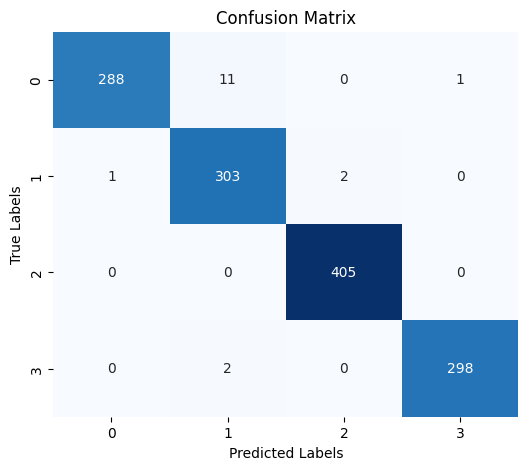

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [40]:
teacher.eval()
student.eval()

teacher_probs = []
student_probs = []
y_true = []

with torch.no_grad():
    for x, y in val_loader:  
        x = x.to(device)
        y = y.to(device)

        teacher_out = teacher(x)
        student_out = student(x)

        
        teacher_probs.append(torch.sigmoid(teacher_out))  
        student_probs.append(torch.sigmoid(student_out))
        y_true.append(y)

In [42]:
teacher_probs = torch.cat(teacher_probs, dim=0)
student_probs = torch.cat(student_probs, dim=0)
y_true = torch.cat(y_true, dim=0)

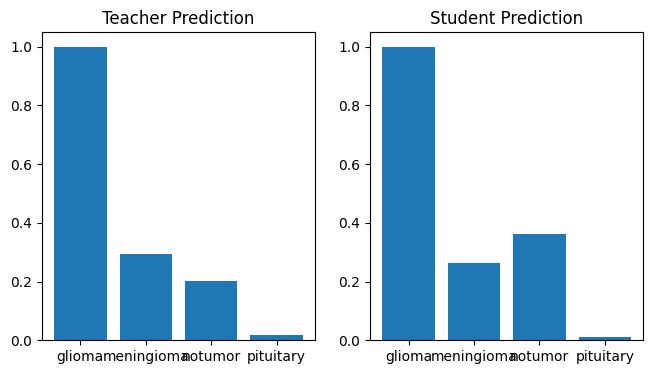

In [46]:
import matplotlib.pyplot as plt
import numpy as np

classes = ["glioma", "meningioma", "notumor", "pituitary"]  #

teacher_pred = teacher_probs[0].cpu().numpy()
student_pred = student_probs[0].cpu().numpy()
true_label = y_true[0].item()  

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.bar(classes, teacher_pred)
plt.title("Teacher Prediction")

plt.subplot(1,3,2)
plt.bar(classes, student_pred)
plt.title("Student Prediction")

plt.show()

In [58]:
image, mask = val_dataset[5]
print("Image shape:", getattr(image, 'shape', image))
print("Mask shape/type:", getattr(mask, 'shape', mask), type(mask))

Image shape: torch.Size([3, 224, 224])
Mask shape/type: 0 <class 'int'>


In [59]:
import torch
import matplotlib.pyplot as plt
import numpy as np

classes = ["glioma", "meningioma", "notumor", "pituitary"]

def visualize_classification_kd(teacher_model, student_model, dataset, idx=0, device='cuda'):
    
    image, label = dataset[idx]
    
   
    x = image.unsqueeze(0).to(device)
    
    teacher_model.to(device).eval()
    student_model.to(device).eval()
    
    with torch.no_grad():
        teacher_out = teacher_model(x)
        student_out = student_model(x)
     
        teacher_probs = torch.softmax(teacher_out[0], dim=0).cpu()
        student_probs = torch.softmax(student_out[0], dim=0).cpu()
    
    plt.figure(figsize=(12,4))
    
 
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(image.cpu().numpy(), (1,2,0)))  # convert C,H,W to H,W,C
    plt.title("MRI Slice")
    plt.axis('off')
    

    plt.subplot(1,3,2)
    plt.bar(classes, teacher_probs.numpy())
    plt.title(f"Teacher Prediction\nGT: {classes[label]}")
    

    plt.subplot(1,3,3)
    plt.bar(classes, student_probs.numpy())
    plt.title(f"Student Prediction\nGT: {classes[label]}")
    
    plt.tight_layout()
    plt.show()


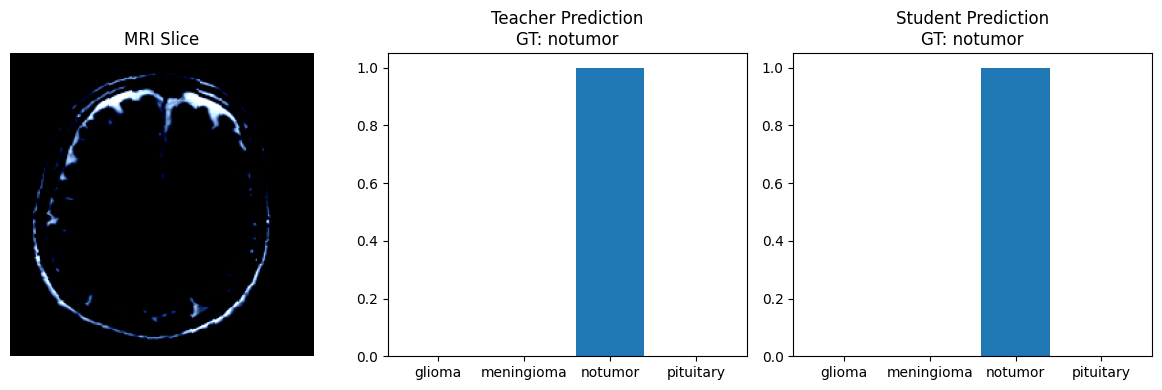

In [62]:
visualize_classification_kd(teacher, student, val_dataset, idx=1000, device='cuda')

In [68]:
!pip install grad-cam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9

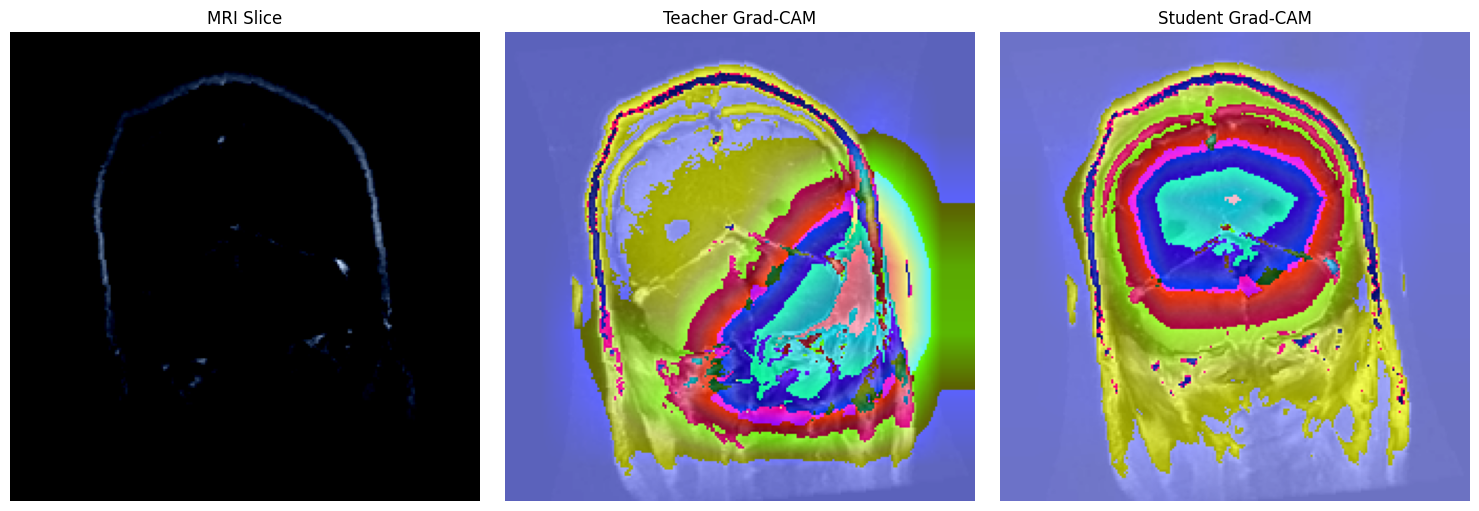

In [75]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

teacher.to(device).eval()
student.to(device).eval()

image, label = val_dataset[5]
x = image.unsqueeze(0).to(device)


img_np = np.transpose(image.cpu().numpy(), (1,2,0))
img_np = img_np / img_np.max()


teacher_layer = teacher.layer4[-1].conv2
teacher_cam = GradCAM(model=teacher, target_layers=[teacher_layer], reshape_transform=None)
teacher_grayscale = teacher_cam(input_tensor=x)[0]
teacher_cam_image = show_cam_on_image(img_np, teacher_grayscale, use_rgb=True)


student_layer = student.features[-1]  # last conv block in MobileNetV3
student_cam = GradCAM(model=student, target_layers=[student_layer], reshape_transform=None)
student_grayscale = student_cam(input_tensor=x)[0]
student_cam_image = show_cam_on_image(img_np, student_grayscale, use_rgb=True)


plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img_np)
plt.title("MRI Slice")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(teacher_cam_image)
plt.title("Teacher Grad-CAM")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(student_cam_image)
plt.title("Student Grad-CAM")
plt.axis('off')

plt.tight_layout()
plt.show()